
=== Dataset Cleaning Summary (Per Source) ===
Facebook:
   Original rows: 210
   Kept rows:     210
   Removed rows:  0 (0.00%)
Instagram:
   Original rows: 3544
   Kept rows:     3544
   Removed rows:  0 (0.00%)
Engagement_Report:
   Original rows: 655
   Kept rows:     655
=== Overall Totals ===
Total original rows: 4409
Total kept rows:     4409
Total removed rows:  0 (0.00%)

Merged rows: (4784, 8)
Skipping day-of-week plot per guidance (date features not used).


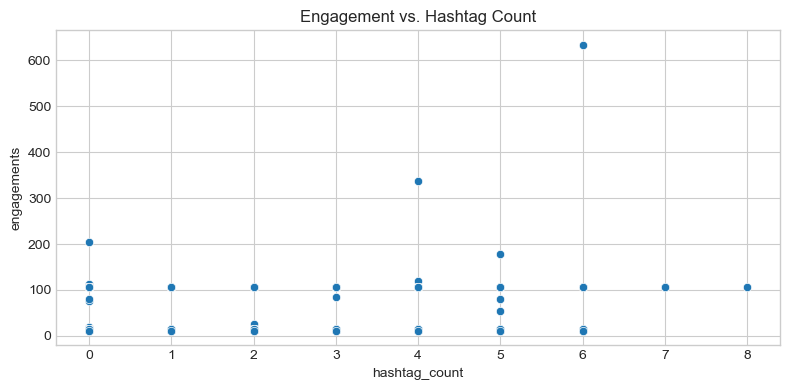

Final dataset exported to: /Users/faitusjelinejoseph/Documents/Project/Social/final_merged_social_data.csv

Sample Output:
    post_date         museum_name  \
0  2024-04-11       Ulster Museum   
1  2024-04-15       Ulster Museum   
2  2024-04-17  American Folk Park   
3  2024-04-18    Transport Museum   
4  2024-04-20  American Folk Park   
5  2024-04-20         Folk Museum   
6  2024-04-21         Folk Museum   
7  2024-04-23         Folk Museum   
8  2024-04-23       Ulster Museum   
9  2024-04-26       Ulster Museum   

                                             caption  platform  \
0  Introducing STEAM Studio, an exciting, new dig...  facebook   
1  Around 60 people from different communities to...  facebook   
2  Coming to Bluegrass Omagh at the Folk Park? Co...  facebook   
3  Fantastic to host the @[100064381375643:2048:N...  facebook   
4  Coming to the Folk Park today? Please note: th...  facebook   
5  Explore the rich biodiversity of the Folk Muse...  facebook   
6  May 

In [11]:
import pandas as pd
import numpy as np
import re
import warnings
warnings.filterwarnings("ignore")

# If you want seaborn/matplotlib later, import below.
import matplotlib.pyplot as plt
import seaborn as sns

# -----------------------------
# 0. Sentiment (VADER) setup
# -----------------------------
import nltk
from nltk.sentiment import SentimentIntensityAnalyzer

def ensure_vader():
    try:
        nltk.data.find("sentiment/vader_lexicon.zip")
    except LookupError:
        nltk.download("vader_lexicon", quiet=True)

ensure_vader()
sia = SentimentIntensityAnalyzer()

# -----------------------------
# 1. Load Data
# -----------------------------
fb_path = "/Users/faitusjelinejoseph/Documents/Project/Social/Final_Facebook_Posts_With_Captions.xlsx"
ig_path = "/Users/faitusjelinejoseph/Documents/Project/Social/Instagram captions.xlsx"
report_path = "/Users/faitusjelinejoseph/Documents/Project/Social/Digital Engagement Report 2024-25.xlsx"

fb_df = pd.read_excel(fb_path, sheet_name='Sheet1')
ig_df = pd.read_excel(ig_path, sheet_name='Sheet1')
report_data = pd.read_excel(report_path, sheet_name=None)
activity_df = report_data['Social Activity Tracker']

# Track original counts (for summary)
orig_counts = {
    "facebook": len(fb_df),
    "instagram": len(ig_df),
    "engagement_report": len(activity_df)
}

# -----------------------------
# 2. Clean Facebook & Instagram
# -----------------------------
# (A) Facebook
fb_df_cleaned = fb_df.rename(columns={
    'Post Date': 'post_date',
    'Museum Name': 'museum_name',
    'Formatted Facebook Caption': 'caption'
})
fb_df_cleaned['platform'] = 'facebook'

# Flags before filling
fb_df_cleaned['caption_missing'] = fb_df_cleaned['caption'].isna() | (fb_df_cleaned['caption'].astype(str).str.strip() == "")
fb_df_cleaned['caption'] = fb_df_cleaned['caption'].fillna("").astype(str)
fb_df_cleaned['post_date'] = pd.to_datetime(fb_df_cleaned['post_date'], errors='coerce').dt.date
fb_df_cleaned['date_missing'] = pd.isna(fb_df_cleaned['post_date'])

fb_df_cleaned = fb_df_cleaned[['post_date', 'museum_name', 'caption', 'platform', 'caption_missing', 'date_missing']]

# (B) Instagram
ig_df_cleaned = ig_df.rename(columns={
    'Date Posted': 'post_date',
    'Museum Site': 'museum_name',
    'Full Caption': 'caption'
})
ig_df_cleaned['platform'] = 'instagram'

ig_df_cleaned['caption_missing'] = ig_df_cleaned['caption'].isna() | (ig_df_cleaned['caption'].astype(str).str.strip() == "")
ig_df_cleaned['caption'] = ig_df_cleaned['caption'].fillna("").astype(str)
ig_df_cleaned['post_date'] = pd.to_datetime(ig_df_cleaned['post_date'], errors='coerce').dt.date
ig_df_cleaned['date_missing'] = pd.isna(ig_df_cleaned['post_date'])

ig_df_cleaned = ig_df_cleaned[['post_date', 'museum_name', 'caption', 'platform', 'caption_missing', 'date_missing']]

# Combine (⚠️ IMPORTANT: do NOT drop — keep rows and use flags)
combined_posts = pd.concat([fb_df_cleaned, ig_df_cleaned], ignore_index=True)

# -----------------------------
# 3. Clean Engagement Report
# -----------------------------
activity_df_cleaned = activity_df.rename(columns={
    'Day': 'day',
    'Month': 'month',
    'Site': 'site',
    'Content Type': 'content_type',
    'Total Active Engagements (Like, Comment, Share, Video >15s)': 'engagements',
    'Total Reach': 'reach'
}).dropna(subset=['site', 'month'])

# Exclude NNMI
activity_df_cleaned = activity_df_cleaned[~activity_df_cleaned['site'].isin(['NNMI'])]

month_str_to_num = {
    'January': 1, 'February': 2, 'March': 3, 'April': 4, 'May': 5, 'June': 6,
    'July': 7, 'August': 8, 'September': 9, 'October': 10, 'November': 11, 'December': 12
}
# Map month names to numbers (leave numeric months untouched)
activity_df_cleaned['month'] = activity_df_cleaned['month'].apply(
    lambda x: month_str_to_num.get(x, x)
)

# Use median-like placeholder 15 ONLY to form a joinable date; not for analysis
activity_df_cleaned['day'] = activity_df_cleaned['day'].fillna(15).astype(int)

# If a Year column exists, use it; else default to 2024 (adjust if needed)
year_val = 2024
for ycol in ['Year', 'year', 'Reporting Year']:
    if ycol in activity_df_cleaned.columns and pd.notna(activity_df_cleaned[ycol]).any():
        try:
            year_val = int(pd.to_numeric(activity_df_cleaned[ycol], errors='coerce').dropna().mode()[0])
            break
        except Exception:
            pass

activity_df_cleaned['post_date'] = pd.to_datetime({
    'year': year_val,
    'month': pd.to_numeric(activity_df_cleaned['month'], errors='coerce'),
    'day': activity_df_cleaned['day']
}, errors='coerce').dt.date

site_to_museum = {
    'UM': 'Ulster Museum',
    'UTM': 'Ulster Transport Museum',
    'UAFP': 'Ulster American Folk Park',
    'AFP': 'Ulster American Folk Park',
    'UFM': 'Ulster Folk Museum'
}
activity_df_cleaned['museum_name'] = activity_df_cleaned['site'].map(site_to_museum)

# Determine platform from content_type text
def _infer_platform(x: str) -> str:
    if not isinstance(x, str):
        return 'unknown'
    s = x.lower()
    if 'facebook' in s: return 'facebook'
    if 'instagram' in s: return 'instagram'
    return 'unknown'

activity_df_cleaned['platform'] = activity_df_cleaned['content_type'].apply(_infer_platform)

# -----------------------------
# 3a. Cleaning Summary (per dataset + overall)
# -----------------------------
kept_fb = int((combined_posts['platform'] == 'facebook').sum())
kept_ig = int((combined_posts['platform'] == 'instagram').sum())
kept_eng = int(len(activity_df_cleaned))

clean_counts = {
    "facebook": kept_fb,
    "instagram": kept_ig,
    "engagement_report": kept_eng
}

def pct(removed, orig):
    return (removed / orig * 100.0) if orig > 0 else 0.0

# In this pipeline we don't drop FB/IG; all original FB/IG rows are kept (after simple renames)
# However, if your source files had extra rows you explicitly excluded above, adjust here.
removed_counts = {
    "facebook": max(0, orig_counts["facebook"] - kept_fb),
    "instagram": max(0, orig_counts["instagram"] - kept_ig),
    "engagement_report": max(0, orig_counts["engagement_report"] - kept_eng),
}
removed_pcts = {k: pct(removed_counts[k], orig_counts[k]) for k in orig_counts}

# Specific FB/IG missing flags (not drops)
fb_missing_caption = int(fb_df_cleaned['caption_missing'].sum())
ig_missing_caption = int(ig_df_cleaned['caption_missing'].sum())
fb_missing_date = int(fb_df_cleaned['date_missing'].sum())
ig_missing_date = int(ig_df_cleaned['date_missing'].sum())

print("\n=== Dataset Cleaning Summary (Per Source) ===")
print("Facebook:")
print(f"   Original rows: {orig_counts['facebook']}")
print(f"   Kept rows:     {clean_counts['facebook']}")
print(f"   Removed rows:  {removed_counts['facebook']} ({removed_pcts['facebook']:.2f}%)")


print("Instagram:")
print(f"   Original rows: {orig_counts['instagram']}")
print(f"   Kept rows:     {clean_counts['instagram']}")
print(f"   Removed rows:  {removed_counts['instagram']} ({removed_pcts['instagram']:.2f}%)")


print("Engagement_Report:")
print(f"   Original rows: {orig_counts['engagement_report']}")
print(f"   Kept rows:     {clean_counts['engagement_report']}")


total_orig = sum(orig_counts.values())
total_kept = sum(clean_counts.values())
total_removed = total_orig - total_kept
total_removed_pct = pct(total_removed, total_orig)
print("=== Overall Totals ===")
print(f"Total original rows: {total_orig}")
print(f"Total kept rows:     {total_kept}")
print(f"Total removed rows:  {total_removed} ({total_removed_pct:.2f}%)\n")

# -----------------------------
# 4. Merge Datasets
# -----------------------------
# NOTE: Keep ALL posts. Do NOT drop rows after merge.
merged_df = pd.merge(
    combined_posts,
    activity_df_cleaned[['post_date', 'museum_name', 'platform', 'engagements', 'reach']],
    on=['post_date', 'museum_name', 'platform'],
    how='left'
)
print("Merged rows:", merged_df.shape)

# -----------------------------
# 5. Feature Engineering
# -----------------------------
merged_df['hashtag_count'] = merged_df['caption'].astype(str).apply(lambda x: x.count('#'))

# We don't have reliable timestamp granularity; keep column but neutralize for modeling
merged_df['hour_of_day'] = 0
merged_df['day_of_week'] = 'N/A'
merged_df['month'] = 'N/A'

# Sentiment
merged_df['sentiment'] = merged_df['caption'].astype(str).apply(lambda x: sia.polarity_scores(x)['compound'])

# -----------------------------
# 6. Visualizations
# -----------------------------
PLOT_DAY_OF_WEEK = False  # per guidance: don't use dates for analysis

if not merged_df.empty:
    if PLOT_DAY_OF_WEEK:
        plt.figure(figsize=(10, 5))
        sns.boxplot(x='day_of_week', y='engagements', data=merged_df)
        plt.title('Engagement by Day of Week')
        plt.xticks(rotation=45)
        plt.tight_layout()
        plt.show()
    else:
        print("Skipping day-of-week plot per guidance (date features not used).")

    plt.figure(figsize=(8, 4))
    sns.scatterplot(x='hashtag_count', y='engagements', data=merged_df)
    plt.title('Engagement vs. Hashtag Count')
    plt.tight_layout()
    plt.show()
else:
    print("No data available for visualization.")

# -----------------------------
# 7. Export Cleaned Dataset
# -----------------------------
out_path = "/Users/faitusjelinejoseph/Documents/Project/Social/final_merged_social_data.csv"
merged_df.to_csv(out_path, index=False)
print(f"Final dataset exported to: {out_path}")

# -----------------------------
# 8. Preview
# -----------------------------
cols_to_show = ['post_date', 'museum_name', 'caption', 'platform',
                'caption_missing', 'date_missing',
                'engagements', 'reach', 'hashtag_count', 'day_of_week', 'month', 'sentiment']
print("\nSample Output:")
print(merged_df[[c for c in cols_to_show if c in merged_df.columns]].head(10))


Loaded: /Users/faitusjelinejoseph/Documents/Project/Social/final_merged_social_data.csv -> (4784, 13)
Best params: {'model__subsample': 0.6, 'model__reg_lambda': 0.0, 'model__reg_alpha': 0.3, 'model__num_leaves': 127, 'model__n_estimators': 200, 'model__min_child_samples': 30, 'model__max_depth': 6, 'model__learning_rate': 0.03, 'model__colsample_bytree': 0.8}
Test RMSE: 2.54
Test MAE : 2.09
Test R^2 : 0.9969

Top 25 features by importance:
                                  feature  importance
3000            museum_name_Ulster Museum         159
2451                                  the         146
1219                                   in          86
1835                                  our          81
3008                          caption_len          79
2676                                   to          69
314                                   and          65
2775                ulstertransportmuseum          62
1736                                   of          56
3007           

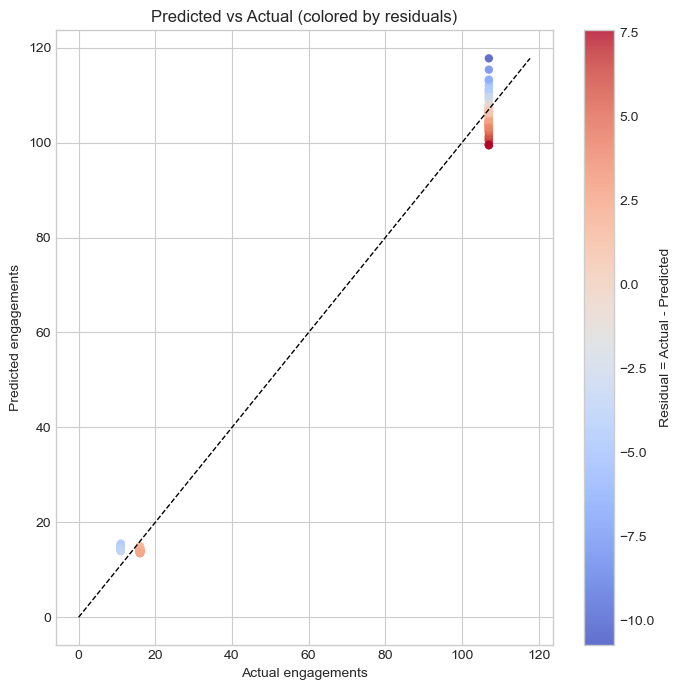

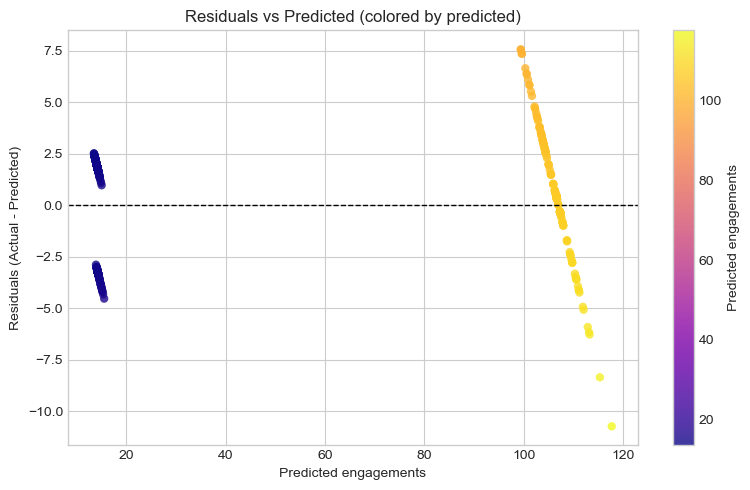

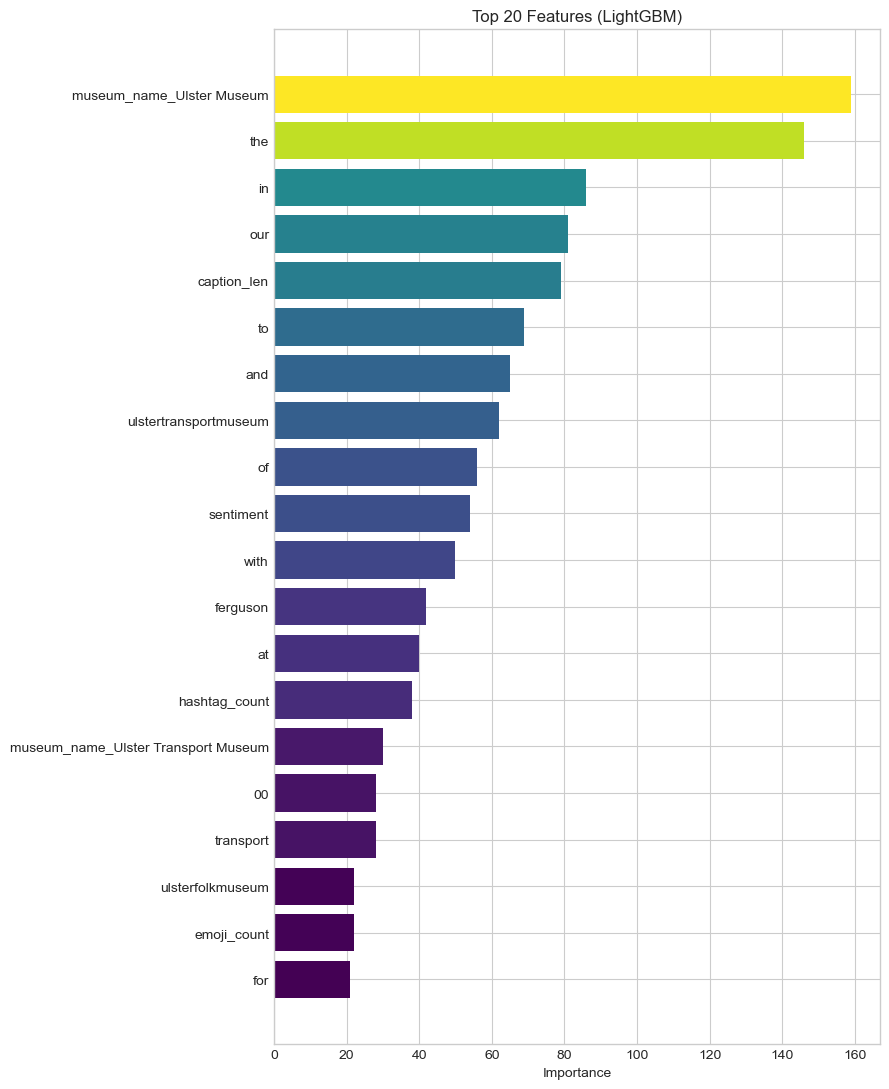

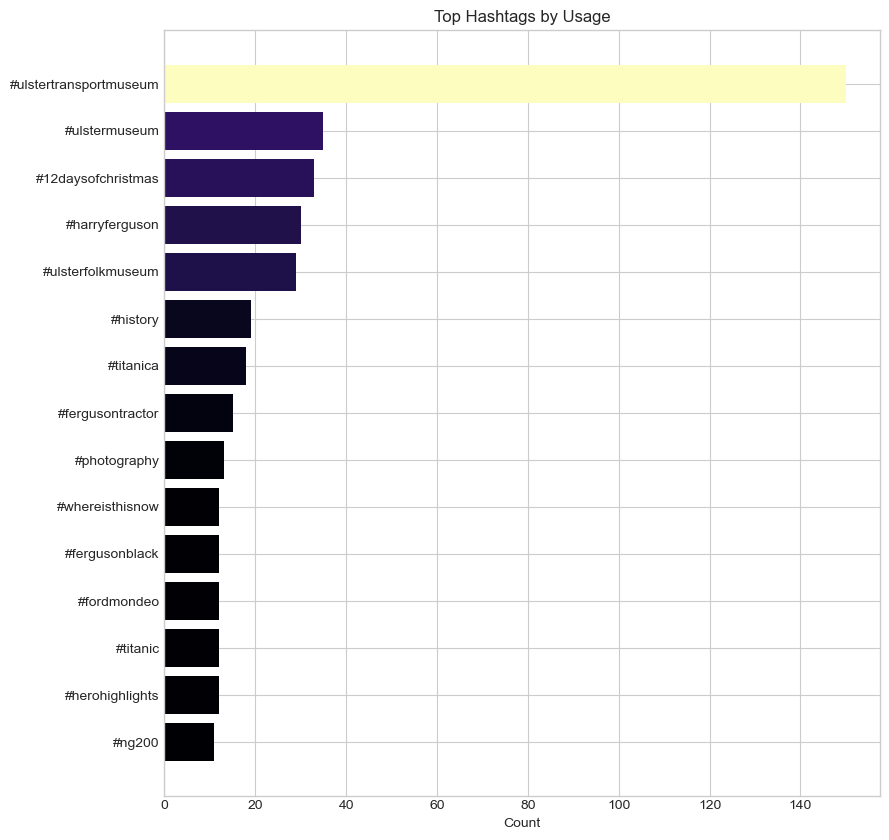

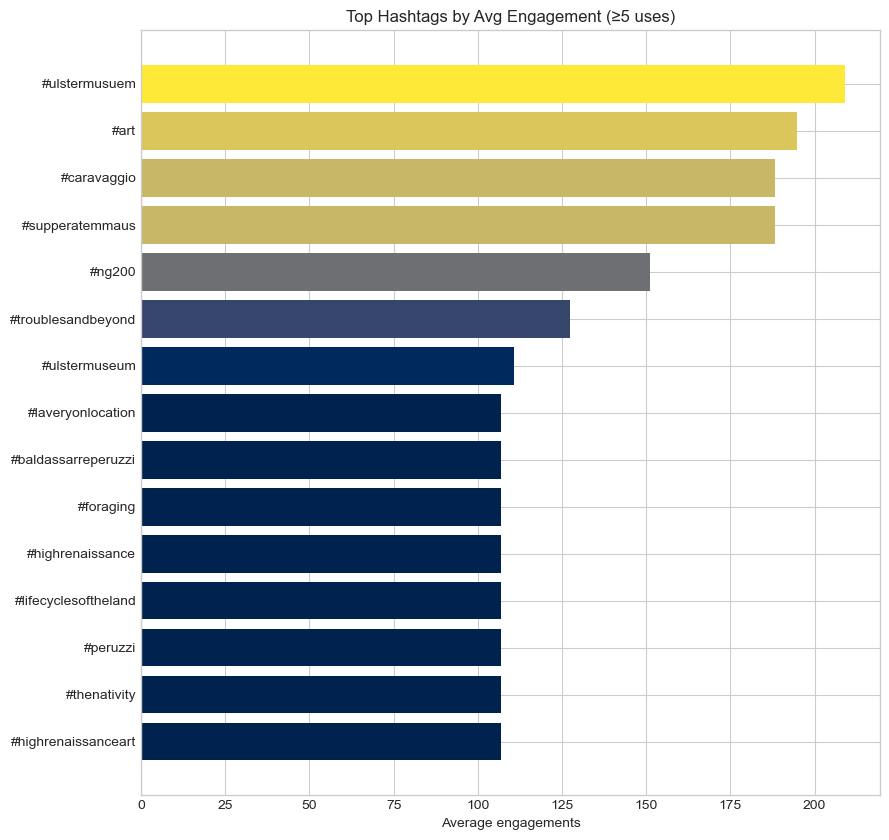

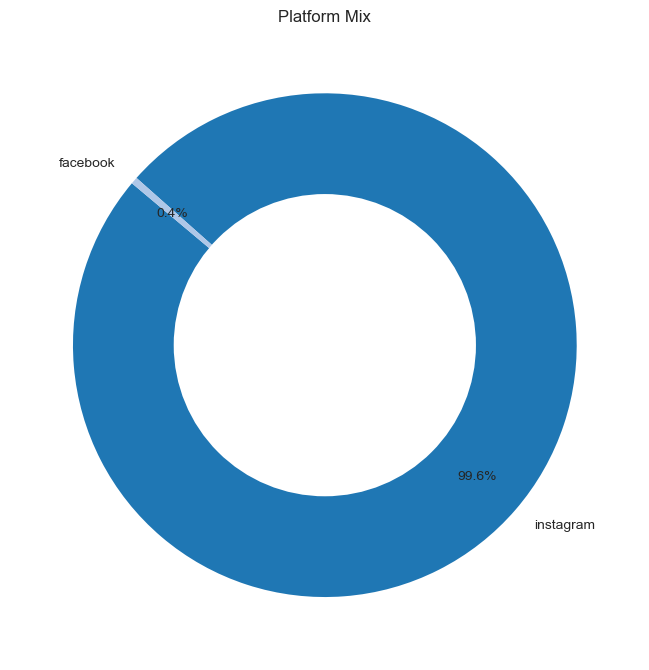

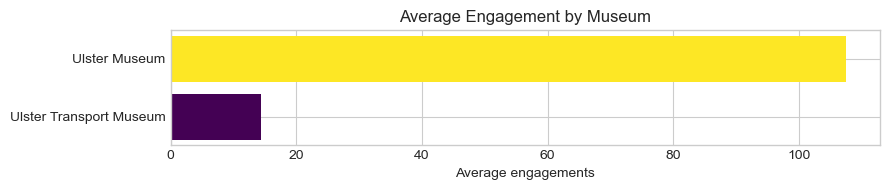

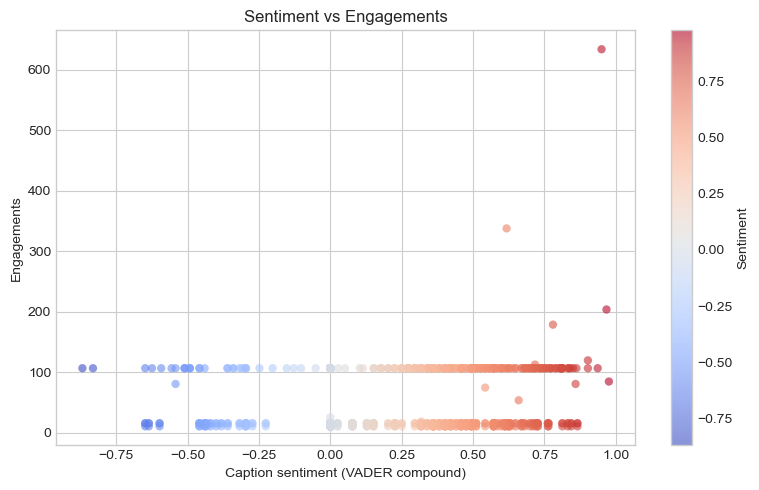

In [7]:
# =============================
# 9) Model-ready features  (reads from CSV, no date-based features)
# =============================
import os, re, math, warnings
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import lightgbm as lgb
from sklearn.exceptions import ConvergenceWarning
import nltk
from nltk.sentiment import SentimentIntensityAnalyzer

warnings.filterwarnings("ignore")
warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings("ignore", category=UserWarning)
warnings.filterwarnings("ignore", category=ConvergenceWarning)
os.environ["PYTHONWARNINGS"] = "ignore"

CSV_PATH = "/Users/faitusjelinejoseph/Documents/Project/Social/final_merged_social_data.csv"
df = pd.read_csv(CSV_PATH)
print(f"Loaded: {CSV_PATH} -> {df.shape}")

# Ensure essential columns exist
for col in ["caption", "engagements", "museum_name", "platform"]:
    if col not in df.columns:
        raise KeyError(f"Missing required column in CSV: {col}")

# --- Per guidance: DO NOT use dates for analysis ---
# If 'day_of_week'/'month' exist, neutralize to a single category so they carry no signal
if "day_of_week" in df.columns:
    df["day_of_week"] = "N/A"
if "month" in df.columns:
    df["month"] = "N/A"

# Sentiment present? If not, add it (text-only, date-agnostic)
if "sentiment" not in df.columns:
    try:
        nltk.data.find('sentiment/vader_lexicon.zip')
    except LookupError:
        nltk.download('vader_lexicon')
    _sia = SentimentIntensityAnalyzer()
    df["sentiment"] = df["caption"].fillna("").apply(lambda t: _sia.polarity_scores(str(t))["compound"])
else:
    _sia = SentimentIntensityAnalyzer()

# Hashtag count present? If not, add it.
if "hashtag_count" not in df.columns:
    df["hashtag_count"] = df["caption"].fillna("").str.count("#")

# Extra lightweight text/structure features
def count_emojis(text):
    if not isinstance(text, str): 
        return 0
    # crude emoji-ish proxy: non-word/space/common punct and not #/@
    return len(re.findall(r"[^\w\s#@.,!?'\-:;()/&]", text))

df["caption"] = df["caption"].fillna("")
df["engagements"] = pd.to_numeric(df["engagements"], errors="coerce")
df = df.dropna(subset=["engagements"])  # must have target

df["caption_len"] = df["caption"].apply(len)
df["word_count"]  = df["caption"].apply(lambda x: len(x.split()))
df["emoji_count"] = df["caption"].apply(count_emojis)

# Target (log1p for stability)
y = np.log1p(df["engagements"].astype(float))

# Feature sets (keep day_of_week/month only if they exist, but they are neutralized to "N/A")
text_col = "caption"
cat_cols = [c for c in ["museum_name", "platform", "day_of_week", "month"] if c in df.columns]
num_cols = [c for c in ["hashtag_count", "sentiment", "caption_len", "word_count", "emoji_count"] if c in df.columns]

X = df[[text_col] + cat_cols + num_cols].copy()

# Train/valid split
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    test_size=0.2,
    random_state=42,
    stratify=None  # regression
)

# =============================
# 10) Preprocessing + Model
# =============================
text_vec = TfidfVectorizer(
    max_features=3000,
    ngram_range=(1, 2),
    min_df=2,
    lowercase=True,
)

cat_enc = OneHotEncoder(handle_unknown='ignore', sparse=True)

from sklearn.compose import ColumnTransformer
preprocess = ColumnTransformer(
    transformers=[
        ('text', text_vec, text_col),
        ('cat',  cat_enc, cat_cols) if cat_cols else ('cat', 'drop', []),
        ('num',  'passthrough', num_cols) if num_cols else ('num', 'drop', [])
    ],
    remainder='drop',
    sparse_threshold=0.3
)

model = lgb.LGBMRegressor(
    objective='regression',
    random_state=42,
    n_estimators=400,
    learning_rate=0.05,
    verbosity=-1
)

from sklearn.pipeline import Pipeline
pipe = Pipeline([
    ('prep', preprocess),
    ('model', model)
])

# =============================
# 11) Model selection (random search)
# =============================
param_dist = {
    'model__n_estimators': [200, 400, 600, 800],
    'model__learning_rate': [0.03, 0.05, 0.1],
    'model__num_leaves': [31, 63, 127],
    'model__max_depth': [-1, 6, 8, 10],
    'model__min_child_samples': [10, 20, 30, 50],
    'model__subsample': [0.6, 0.8, 1.0],
    'model__colsample_bytree': [0.6, 0.8, 1.0],
    'model__reg_alpha': [0.0, 0.1, 0.3],
    'model__reg_lambda': [0.0, 0.5, 1.0],
}

from sklearn.model_selection import RandomizedSearchCV
search = RandomizedSearchCV(
    estimator=pipe,
    param_distributions=param_dist,
    n_iter=25,
    cv=5,
    n_jobs=-1,
    random_state=42,
    scoring='neg_root_mean_squared_error',
    verbose=0
)

with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    search.fit(X_train, y_train)

best_pipe = search.best_estimator_
print("Best params:", search.best_params_)

# =============================
# 12) Evaluation (on original scale)
# =============================
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

y_pred_log = best_pipe.predict(X_test)
y_pred = np.expm1(y_pred_log)         # invert the log1p
y_true = np.expm1(y_test.to_numpy())

rmse = math.sqrt(mean_squared_error(y_true, y_pred))
mae  = mean_absolute_error(y_true, y_pred)
r2   = r2_score(y_true, y_pred)

print(f"Test RMSE: {rmse:,.2f}")
print(f"Test MAE : {mae:,.2f}")
print(f"Test R^2 : {r2:.4f}")

# =============================
# 13) Feature importance (global)
# =============================
def get_feature_names_from_ct(ct: ColumnTransformer):
    names = []
    for name, trans, cols in ct.transformers_:
        if name == 'remainder' and trans == 'drop':
            continue
        if hasattr(trans, 'get_feature_names_out'):
            if isinstance(trans, OneHotEncoder):
                feats = trans.get_feature_names_out(cols)
            else:
                feats = trans.get_feature_names_out()
            names.extend(list(feats))
        elif trans == 'passthrough':
            if isinstance(cols, list):
                names.extend(cols)
            else:
                names.append(cols)
        else:
            if isinstance(cols, list):
                names.extend([f"{name}__{c}" for c in cols])
            else:
                names.append(f"{name}__{cols}")
    return np.array(names)

lgbm = best_pipe.named_steps['model']
ct   = best_pipe.named_steps['prep']
feat_names = get_feature_names_from_ct(ct)

importances = pd.DataFrame({
    'feature': feat_names,
    'importance': lgbm.feature_importances_
}).sort_values('importance', ascending=False)

print("\nTop 25 features by importance:")
print(importances.head(25))

# =============================
# 14) Optimal hashtags (data-driven)
# =============================
def extract_hashtags(text):
    if not isinstance(text, str): return []
    return [h.lower() for h in re.findall(r'#\w+', text)]

need_cols = ['caption', 'engagements', 'museum_name', 'platform']
for c in need_cols:
    if c not in df.columns:
        df[c] = np.nan

# We keep day_of_week/month columns if they exist (will be "N/A")
extra_cols = [c for c in ['day_of_week', 'month'] if c in df.columns]
tag_df = df[need_cols + extra_cols].copy()
tag_df['hashtags'] = tag_df['caption'].apply(extract_hashtags)
tag_exp = tag_df.explode('hashtags').dropna(subset=['hashtags'])

counts = tag_exp.groupby('hashtags').size().rename('count')
means  = tag_exp.groupby('hashtags')['engagements'].mean().rename('avg_engagement')
tag_stats = pd.concat([counts, means], axis=1).reset_index().sort_values('avg_engagement', ascending=False)

print("\nHashtag stats (top 15 by avg engagement, any frequency):")
print(tag_stats.head(15))

# =============================
# 15) Best posting day per museum (SKIPPED per guidance)
# =============================
if 'day_of_week' in df.columns and df['day_of_week'].nunique() > 1:
    print("\n[Skipped] Best posting day per museum — date-based analysis disabled by guidance.")
else:
    print("\nBest posting day per museum skipped (no date features used / single neutral category).")

# =============================
# 16) Predict for a *new* post (pre-publish) — ignores date
# =============================
def predict_engagement(caption, museum_name, platform, post_date=None):
    """
    Per guidance, we IGNORE post_date (no date effects).
    """
    cap = caption or ""
    row = {
        'caption': cap,
        'museum_name': museum_name,
        'platform': platform,
        # Keep columns consistent; if present in training, set to neutral
        'day_of_week': 'N/A' if 'day_of_week' in X.columns else np.nan,
        'month': 'N/A' if 'month' in X.columns else np.nan,
        'hashtag_count': cap.count('#'),
        'sentiment': _sia.polarity_scores(cap)['compound'],
        'caption_len': len(cap),
        'word_count': len(cap.split()),
        'emoji_count': count_emojis(cap),
    }
    X_new = pd.DataFrame([row])
    pred_log = best_pipe.predict(X_new)[0]
    return float(max(0.0, np.expm1(pred_log)))

# =============================
# 17) Colorful Visuals (no date features)
# =============================
import os, re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import cm

PLOT_DIR = "/Users/faitusjelinejoseph/Documents/Project/Social/plots"
os.makedirs(PLOT_DIR, exist_ok=True)
plt.style.use("seaborn-v0_8-whitegrid")  # clean, color-friendly base

def _cm_colors(values, cmap_name="viridis"):
    """Map 1D numeric array -> RGBA colors using a colormap."""
    values = np.asarray(values, dtype=float)
    vmin, vmax = float(np.nanmin(values)), float(np.nanmax(values))
    if np.isclose(vmin, vmax):
        vmax = vmin + 1.0
    norm = plt.Normalize(vmin=vmin, vmax=vmax)
    cmap = cm.get_cmap(cmap_name)
    return cmap(norm(values))

# ---- 17.1 Predicted vs Actual (colored by residuals) ----
try:
    residuals = y_true - y_pred
    sc_cmap = "coolwarm"
    plt.figure(figsize=(7, 7))
    sc = plt.scatter(y_true, y_pred, c=residuals, cmap=sc_cmap, alpha=0.8, edgecolor="none")
    mx = max(float(np.max(y_true)), float(np.max(y_pred))) if len(y_true) else 1.0
    plt.plot([0, mx], [0, mx], linestyle="--", color="black", linewidth=1.0)
    plt.xlabel("Actual engagements")
    plt.ylabel("Predicted engagements")
    plt.title("Predicted vs Actual (colored by residuals)")
    cbar = plt.colorbar(sc)
    cbar.set_label("Residual = Actual - Predicted")
    plt.tight_layout()
    plt.savefig(os.path.join(PLOT_DIR, "pred_vs_actual_color.png"), dpi=150)
    plt.show()
except Exception as e:
    print(f"[Skip] Predicted vs Actual plot: {e}")

# ---- 17.2 Residuals vs Predicted (colored by predicted) ----
try:
    plt.figure(figsize=(8, 5))
    sc = plt.scatter(y_pred, residuals, c=y_pred, cmap="plasma", alpha=0.8, edgecolor="none")
    plt.axhline(0, linestyle="--", color="black", linewidth=1.0)
    plt.xlabel("Predicted engagements")
    plt.ylabel("Residuals (Actual - Predicted)")
    plt.title("Residuals vs Predicted (colored by predicted)")
    cbar = plt.colorbar(sc)
    cbar.set_label("Predicted engagements")
    plt.tight_layout()
    plt.savefig(os.path.join(PLOT_DIR, "residuals_vs_pred_color.png"), dpi=150)
    plt.show()
except Exception as e:
    print(f"[Skip] Residuals vs Predicted plot: {e}")

# ---- 17.3 Feature importances (Top 20, colorful barh) ----
try:
    if isinstance(importances, pd.DataFrame) and not importances.empty:
        top_n = 20
        top_imp = importances.head(top_n).iloc[::-1]  # reverse for barh
        cols = _cm_colors(top_imp["importance"].values, "viridis")

        plt.figure(figsize=(9, 0.5 * len(top_imp) + 1))
        plt.barh(top_imp["feature"], top_imp["importance"], color=cols)
        plt.xlabel("Importance")
        plt.title(f"Top {len(top_imp)} Features (LightGBM)")
        plt.tight_layout()
        plt.savefig(os.path.join(PLOT_DIR, "feature_importance_top_color.png"), dpi=150)
        plt.show()
    else:
        print("[Info] No importances available to plot.")
except Exception as e:
    print(f"[Skip] Feature importance plot: {e}")

# ---- 17.4 Top hashtags by usage (color by count) ----
try:
    def extract_hashtags(text):
        if not isinstance(text, str): return []
        return [h.lower() for h in re.findall(r'#\w+', text)]

    tmp = df[['caption','engagements']].copy()
    tmp["caption"] = tmp["caption"].fillna("")
    tmp["hashtags"] = tmp["caption"].apply(extract_hashtags)
    tmp = tmp.explode("hashtags").dropna(subset=["hashtags"])
    top_cnt = (tmp["hashtags"].value_counts()
               .head(15)
               .rename_axis("hashtags")
               .reset_index(name="count"))

    if not top_cnt.empty:
        d = top_cnt.iloc[::-1]
        cols = _cm_colors(d["count"].values, "magma")
        plt.figure(figsize=(9, 0.5 * len(d) + 1))
        plt.barh(d["hashtags"], d["count"], color=cols)
        plt.xlabel("Count")
        plt.title("Top Hashtags by Usage")
        plt.tight_layout()
        plt.savefig(os.path.join(PLOT_DIR, "top_hashtags_usage_color.png"), dpi=150)
        plt.show()
    else:
        print("[Info] No hashtags found for usage plot.")
except Exception as e:
    print(f"[Skip] Top hashtags by usage plot: {e}")

# ---- 17.5 Top hashtags by average engagement (min 5 uses; color by avg_engagement) ----
try:
    grp = (tmp.groupby("hashtags")["engagements"]
             .agg(count="size", avg_engagement="mean")
             .query("count >= 5")
             .sort_values(["avg_engagement","count"], ascending=[False, False])
             .head(15)
             .reset_index())

    if not grp.empty:
        d = grp.iloc[::-1]
        cols = _cm_colors(d["avg_engagement"].values, "cividis")
        plt.figure(figsize=(9, 0.5 * len(d) + 1))
        plt.barh(d["hashtags"], d["avg_engagement"], color=cols)
        plt.xlabel("Average engagements")
        plt.title("Top Hashtags by Avg Engagement (≥5 uses)")
        plt.tight_layout()
        plt.savefig(os.path.join(PLOT_DIR, "top_hashtags_avg_color.png"), dpi=150)
        plt.show()
    else:
        print("[Info] No hashtags satisfy min-uses=5 for avg engagement plot.")
except Exception as e:
    print(f"[Skip] Top hashtags by avg engagement plot: {e}")

# ---- 17.6 Platform mix (colorful donut) ----
try:
    if "platform" in df.columns:
        counts = df["platform"].fillna("unknown").value_counts()
        labels = counts.index.tolist()
        sizes = counts.values
        cmap = cm.get_cmap("tab20")
        colors = [cmap(i % cmap.N) for i in range(len(labels))]

        plt.figure(figsize=(6.8, 6.8))
        wedges, texts, autotexts = plt.pie(
            sizes, labels=labels, autopct="%1.1f%%",
            startangle=140, colors=colors, pctdistance=0.8
        )
        centre_circle = plt.Circle((0,0),0.60,fc="white")
        fig = plt.gcf()
        fig.gca().add_artist(centre_circle)
        plt.title("Platform Mix")
        plt.tight_layout()
        plt.savefig(os.path.join(PLOT_DIR, "platform_mix_donut.png"), dpi=150)
        plt.show()
    else:
        print("[Info] 'platform' column not found for platform mix.")
except Exception as e:
    print(f"[Skip] Platform mix plot: {e}")

# ---- 17.7 Museum averages (color by avg engagement) ----
try:
    if "museum_name" in df.columns:
        mus = (df.groupby("museum_name")["engagements"]
                 .mean()
                 .sort_values(ascending=False)
                 .reset_index()
                 .rename(columns={"engagements":"avg_engagement"}))
        if not mus.empty:
            d = mus.iloc[::-1]
            cols = _cm_colors(d["avg_engagement"].values, "viridis")
            plt.figure(figsize=(9, 0.5 * len(d) + 1))
            plt.barh(d["museum_name"], d["avg_engagement"], color=cols)
            plt.xlabel("Average engagements")
            plt.title("Average Engagement by Museum")
            plt.tight_layout()
            plt.savefig(os.path.join(PLOT_DIR, "avg_engagement_by_museum.png"), dpi=150)
            plt.show()
        else:
            print("[Info] No museum data available.")
    else:
        print("[Info] 'museum_name' column not found for museum averages.")
except Exception as e:
    print(f"[Skip] Museum averages plot: {e}")

# ---- 17.8 Sentiment vs Engagements (colored by sentiment) ----
try:
    if "sentiment" in df.columns and not df["sentiment"].isna().all():
        x = pd.to_numeric(df["sentiment"], errors="coerce")
        y_vals = pd.to_numeric(df["engagements"], errors="coerce")
        mask = (~x.isna()) & (~y_vals.isna())
        x, y_vals = x[mask], y_vals[mask]
        plt.figure(figsize=(8, 5))
        sc = plt.scatter(x, y_vals, c=x, cmap="coolwarm", alpha=0.6, edgecolor="none")
        plt.xlabel("Caption sentiment (VADER compound)")
        plt.ylabel("Engagements")
        plt.title("Sentiment vs Engagements")
        cbar = plt.colorbar(sc)
        cbar.set_label("Sentiment")
        plt.tight_layout()
        plt.savefig(os.path.join(PLOT_DIR, "sentiment_vs_engagements.png"), dpi=150)
        plt.show()
    else:
        print("[Info] Sentiment column not available for plotting.")
except Exception as e:
    print(f"[Skip] Sentiment vs Engagements plot: {e}")


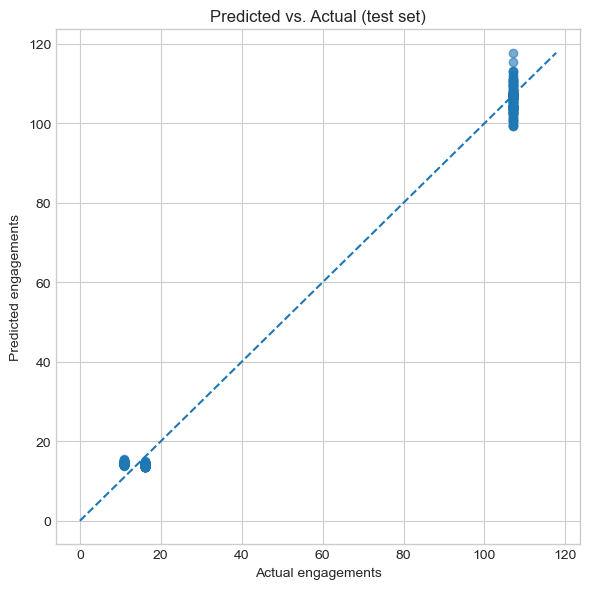

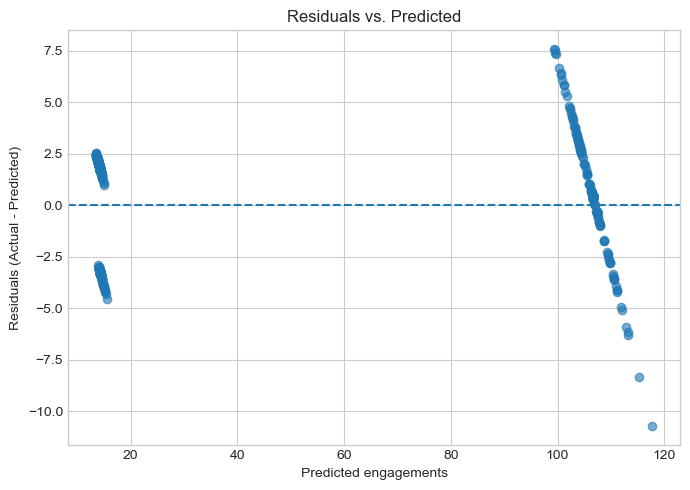

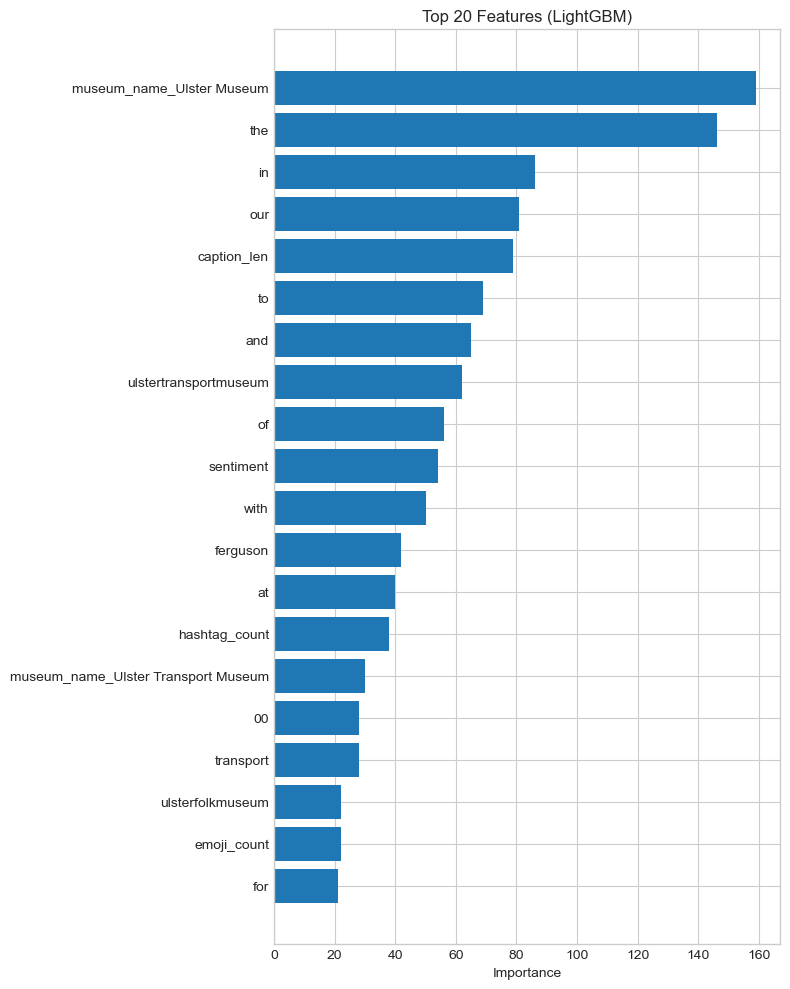

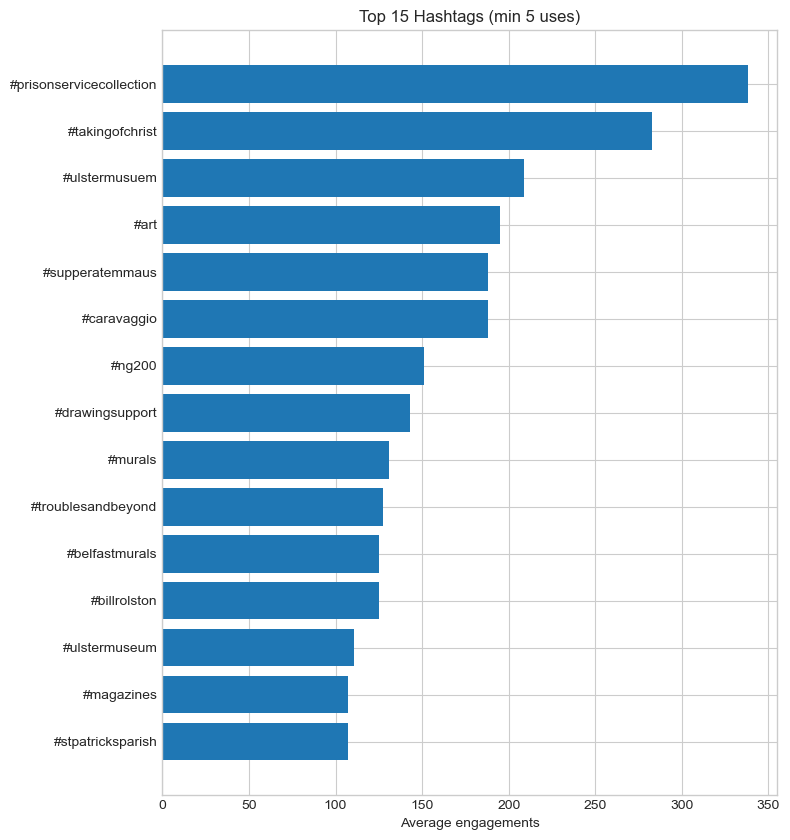

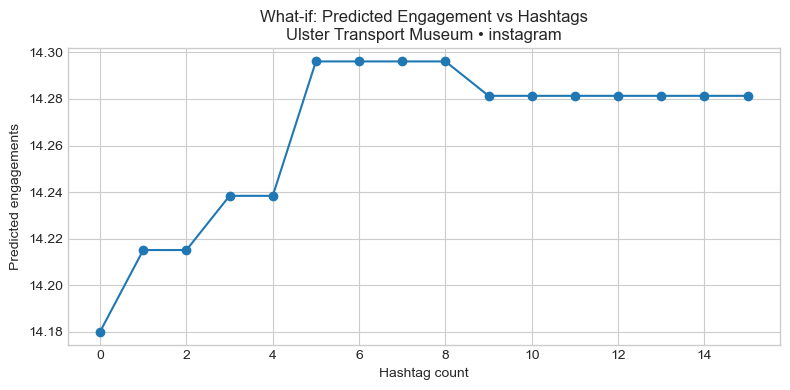

In [8]:
# =============================
# 17) Visualizations (no date/day analysis)
# =============================
import os, re
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

PLOT_DIR = "/Users/faitusjelinejoseph/Documents/Project/Social/plots"
os.makedirs(PLOT_DIR, exist_ok=True)

# Recompute y_true/y_pred on test for safety (uses best_pipe, X_test, y_test)
y_pred_log = best_pipe.predict(X_test)
y_pred = np.expm1(y_pred_log)
y_true = np.expm1(y_test.to_numpy())

# ---- 17.1 Predicted vs. Actual ----
plt.figure(figsize=(6, 6))
plt.scatter(y_true, y_pred, alpha=0.6)
mx = max(float(np.max(y_true)), float(np.max(y_pred))) if len(y_true) else 1.0
plt.plot([0, mx], [0, mx], linestyle='--')
plt.xlabel("Actual engagements")
plt.ylabel("Predicted engagements")
plt.title("Predicted vs. Actual (test set)")
plt.tight_layout()
plt.savefig(os.path.join(PLOT_DIR, "predicted_vs_actual.png"), dpi=150)
plt.show()

# ---- 17.2 Residuals vs. Prediction ----
residuals = y_true - y_pred
plt.figure(figsize=(7, 5))
plt.scatter(y_pred, residuals, alpha=0.6)
plt.axhline(0, linestyle='--')
plt.xlabel("Predicted engagements")
plt.ylabel("Residuals (Actual - Predicted)")
plt.title("Residuals vs. Predicted")
plt.tight_layout()
plt.savefig(os.path.join(PLOT_DIR, "residuals_vs_predicted.png"), dpi=150)
plt.show()

# ---- 17.3 Top feature importances ----
top_n = 20
if 'importances_sorted' in globals():
    _imp = importances_sorted.copy()
elif 'importances' in globals():
    _imp = importances.copy()
else:
    _imp = pd.DataFrame(columns=['feature', 'importance'])

if 'perm' in _imp.columns:
    importance_df = _imp[['feature', 'perm']].rename(columns={'perm': 'importance'})
    xlabel = "Importance (permutation)"
elif 'gain' in _imp.columns:
    importance_df = _imp[['feature', 'gain']].rename(columns={'gain': 'importance'})
    xlabel = "Importance (gain)"
elif 'importance' in _imp.columns:
    importance_df = _imp[['feature', 'importance']]
    xlabel = "Importance"
else:
    importance_df = pd.DataFrame({'feature': [], 'importance': []})
    xlabel = "Importance"

top_imp = importance_df.head(top_n).iloc[::-1]  # reverse for barh
plt.figure(figsize=(8, 0.45 * max(1, len(top_imp)) + 1))
plt.barh(top_imp["feature"], top_imp["importance"])
plt.xlabel(xlabel)
plt.title(f"Top {len(top_imp)} Features (LightGBM)")
plt.xlim(left=0)
plt.tight_layout()
plt.savefig(os.path.join(PLOT_DIR, "feature_importance_top.png"), dpi=150)
plt.show()

# ---- 17.4 Best hashtags by average engagement ----
if 'tag_stats' in globals() and isinstance(tag_stats, pd.DataFrame) and not tag_stats.empty:
    top_tags_n = 15
    ts = tag_stats.head(top_tags_n).iloc[::-1]
    plt.figure(figsize=(8, 0.5 * min(top_tags_n, len(ts)) + 1))
    plt.barh(ts["hashtags"], ts["avg_engagement"])
    plt.xlabel("Average engagements")
    plt.title(f"Top {min(top_tags_n, len(ts))} Hashtags (min 5 uses)")
    plt.tight_layout()
    plt.savefig(os.path.join(PLOT_DIR, "top_hashtags.png"), dpi=150)
    plt.show()
else:
    print("No hashtag stats available to plot (tag_stats empty).")


# ---- 17.6 What-if: predicted engagement vs hashtag count ----
def plot_predicted_vs_hashtags(
    museum_name=None, platform=None, base_caption="Great exhibits today", max_hashtags=15
):
    # defaults
    if museum_name is None:
        museum_name = merged_df["museum_name"].dropna().mode().iloc[0]
    if platform is None:
        platform = merged_df["platform"].dropna().mode().iloc[0]

    counts = list(range(0, max_hashtags + 1))
    preds = []
    for k in counts:
        tags = " ".join([f"#tag{i}" for i in range(1, k + 1)])
        cap = (base_caption + " " + tags).strip()
        preds.append(predict_engagement(
            caption=cap,
            museum_name=museum_name,
            platform=platform
        ))

    plt.figure(figsize=(8, 4))
    plt.plot(counts, preds, marker='o')
    plt.xlabel("Hashtag count")
    plt.ylabel("Predicted engagements")
    plt.title(f"What-if: Predicted Engagement vs Hashtags\n{museum_name} • {platform}")
    plt.tight_layout()
    plt.savefig(os.path.join(PLOT_DIR, "whatif_vs_hashtags.png"), dpi=150)
    plt.show()

# Example run
plot_predicted_vs_hashtags()


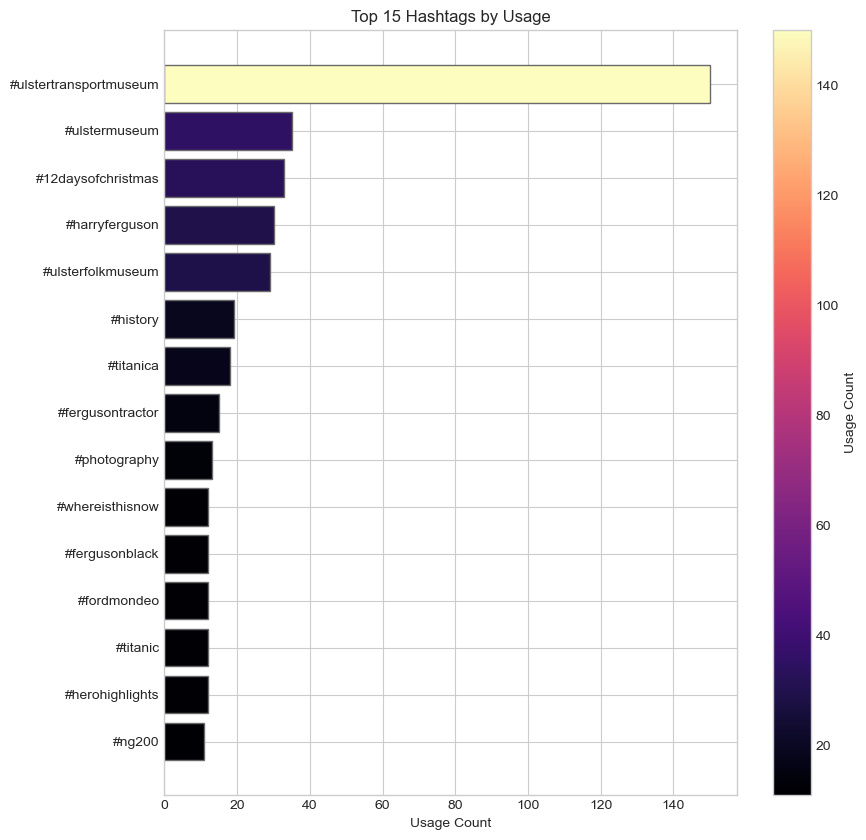

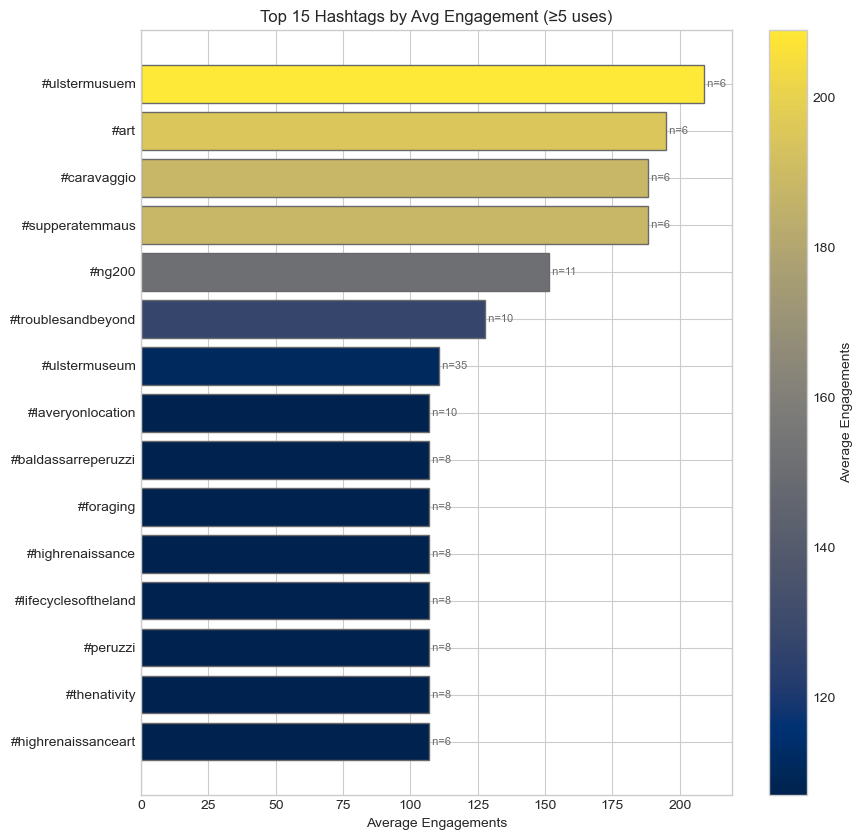

In [4]:
import matplotlib.pyplot as plt
from matplotlib import cm
import numpy as np
import pandas as pd

# --- data prep (unchanged) ---
tmp = df[['caption','engagements']].copy()
tmp['caption'] = tmp['caption'].fillna('')
tmp['engagements'] = pd.to_numeric(tmp['engagements'], errors='coerce')
tmp['hashtags'] = tmp['caption'].apply(extract_hashtags)
tmp = tmp.explode('hashtags').dropna(subset=['hashtags', 'engagements'])

top_cnt = (tmp['hashtags'].value_counts()
           .head(15)
           .rename_axis('hashtags')
           .reset_index(name='count'))

top_avg = (tmp.groupby('hashtags')['engagements']
             .agg(count='size', avg_engagement='mean')
             .query('count >= 5')
             .sort_values(['avg_engagement','count'], ascending=[False, False])
             .head(15)
             .reset_index())

# -----------------------------
# Bar helpers (replacing boxplot)
# -----------------------------
def _barh_by_hashtag(tags_df, x_col, title, cmap_name="viridis", annotate=None, xlabel=None):
    """
    tags_df: dataframe with columns ['hashtags', x_col] (and optionally 'count' for annotations)
    x_col:   column to plot on X (e.g., 'count' or 'avg_engagement')
    annotate: None | 'count' -> adds 'n={count}' labels next to bars when available
    """
    if tags_df.empty:
        print(f"No data for: {title}")
        return

    dfp = tags_df.copy()
    dfp = dfp.iloc[::-1]  # highest at top

    # Color scale by x_col
    vals = dfp[x_col].to_numpy(dtype=float)
    vmin = float(np.nanmin(vals))
    vmax = float(np.nanmax(vals)) if not np.isclose(vmin, float(np.nanmax(vals))) else vmin + 1.0
    norm = plt.Normalize(vmin=vmin, vmax=vmax)
    cmap = cm.get_cmap(cmap_name)
    colors = [cmap(norm(v)) for v in vals]

    plt.figure(figsize=(9, 0.5 * len(dfp) + 1))
    bars = plt.barh(dfp['hashtags'], dfp[x_col], color=colors, edgecolor='dimgray')
    plt.title(title)
    plt.xlabel(xlabel or x_col.replace('_', ' ').title())
    plt.tight_layout()

    # colorbar legend
    sm = cm.ScalarMappable(norm=norm, cmap=cmap)
    sm.set_array([])
    cbar = plt.colorbar(sm)
    cbar.set_label((xlabel or x_col.replace('_', ' ').title()))

    # optional annotations (e.g., show sample size)
    if annotate and annotate in dfp.columns:
        for bar, n in zip(bars, dfp[annotate].tolist()):
            x = bar.get_width()
            y = bar.get_y() + bar.get_height()/2
            plt.text(x, y, f" n={int(n)}", va="center", ha="left", fontsize=8, color="dimgray")

    plt.show()

# --- Bar: Top hashtags by usage (colored by count) ---
_barh_by_hashtag(
    tags_df=top_cnt[['hashtags', 'count']],
    x_col='count',
    title='Top 15 Hashtags by Usage',
    cmap_name='magma',
    annotate=None,
    xlabel='Usage Count'
)

# --- Bar: Top hashtags by avg engagement (≥5 uses; colored by avg_engagement) ---
_barh_by_hashtag(
    tags_df=top_avg[['hashtags','avg_engagement','count']],
    x_col='avg_engagement',
    title='Top 15 Hashtags by Avg Engagement (≥5 uses)',
    cmap_name='cividis',
    annotate='count',
    xlabel='Average Engagements'
)



=== Engagement by Category ===
     category  count   mean  median    max
0     history      1  338.0   338.0  338.0
1         art     10  156.4    99.0  634.0
2  exhibition      1   81.0    81.0   81.0
3     general      1   26.0    26.0   26.0

=== Top Captions per Category ===
       category                                            caption  \
48          art  At the beginning of July we took a 24-hour tim...   
51      history  In 2018, the Ulster Museum received a donation...   
34          art  Go for Gold! Congratulations to Daniel Wiffen,...   
53          art  Bill Rolston has been photographing murals in ...   
52   exhibition  🪡 When words are not enough to express lived e...   
121     general  your own rag wreath and explore rag rugs in ou...   

     engagements    museum_name   platform  
48         634.0  Ulster Museum   facebook  
51         338.0  Ulster Museum   facebook  
34         204.0  Ulster Museum   facebook  
53         179.0  Ulster Museum   facebook  
52

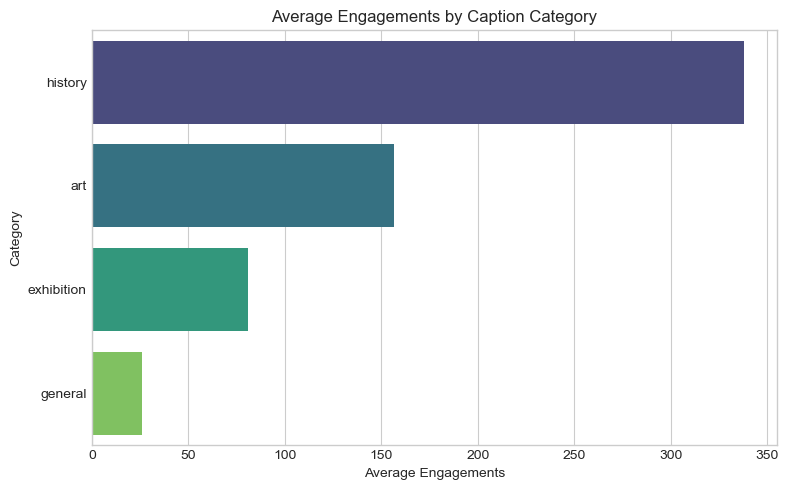


Top captions for category: art
  - (634.0 engagements) At the beginning of July we took a 24-hour timelapse to see how the natural light in the gallery changed The Taking of C...
  - (204.0 engagements) Go for Gold! Congratulations to Daniel Wiffen, Jack McMillan and Hannah Scott on winning gold medals in the Paris Olympi...
  - (179.0 engagements) Bill Rolston has been photographing murals in Northern Ireland since 1981.

In this fascinating Curator Tour, Bill discu...

Top captions for category: history
  - (338.0 engagements) In 2018, the Ulster Museum received a donation from the Northern Ireland Prison Service - material which related predomi...

Top captions for category: exhibition
  - (81.0 engagements) 🪡 When words are not enough to express lived experiences of violence, stitching and sewing emerge as textile language.

...

Top captions for category: general
  - (26.0 engagements) your own rag wreath and explore rag rugs in our collection → link in bio! #UlsterFolkMuseum #Ma

In [8]:
# =============================
# 7) Create Caption Categories
# =============================

import matplotlib.pyplot as plt
import seaborn as sns

category_keywords = {
    "art": ["art", "artwork", "gallery", "visual"],
    "painting": ["painting", "paintings", "portrait", "canvas"],
    "exhibition": ["exhibition", "exhibit", "showcase", "display"],
    "history": ["history", "heritage", "historic", "ancient"],
    "science": ["science", "experiment", "discovery", "research"],
    "family": ["family", "kids", "children", "parents"],
    "event": ["event", "festival", "celebration", "concert"],
    "general": []  # fallback if no match
}

def categorize_caption(caption: str) -> str:
    caption_lower = str(caption).lower()
    for cat, keywords in category_keywords.items():
        if any(kw in caption_lower for kw in keywords):
            return cat
    return "general"

merged_df["category"] = merged_df["caption"].apply(categorize_caption)

# =============================
# 8) Analyze Categories
# =============================

# Engagement by category
cat_stats = (merged_df.groupby("category")["engagements"]
             .agg(["count", "mean", "median", "max"])
             .sort_values("mean", ascending=False)
             .reset_index())

print("\n=== Engagement by Category ===")
print(cat_stats)

# Best-performing captions per category
top_captions = (merged_df
    .sort_values("engagements", ascending=False)
    .groupby("category")
    .head(3)   # top 3 per category
    [["category", "caption", "engagements", "museum_name", "platform"]])

print("\n=== Top Captions per Category ===")
print(top_captions)

# =============================
# 8a) Visualizations
# =============================

PLOT_DIR = "/Users/faitusjelinejoseph/Documents/Project/Social/plots"
os.makedirs(PLOT_DIR, exist_ok=True)

# ---- Engagement by Category (barplot) ----
plt.figure(figsize=(8,5))
sns.barplot(x="mean", y="category", data=cat_stats, palette="viridis")
plt.xlabel("Average Engagements")
plt.ylabel("Category")
plt.title("Average Engagements by Caption Category")
plt.tight_layout()
plt.savefig(os.path.join(PLOT_DIR, "avg_engagement_by_category.png"), dpi=150)
plt.show()

# ---- Top Captions per Category (text display) ----
for cat in top_captions["category"].unique():
    sub = top_captions[top_captions["category"] == cat]
    print(f"\nTop captions for category: {cat}")
    for _, row in sub.iterrows():
        print(f"  - ({row['engagements']} engagements) {row['caption'][:120]}...")




=== Top Emojis by Usage ===
   emoji_list  count  avg_engagement
2           0   5227       56.056928
4           2   3160       52.980127
3           1   2350       59.926752
6           4   2064       61.706177
0           #   1837       52.484712
8           6   1223       72.384615
10          8   1208       61.806691
7           5   1104       52.223022
9           7   1058       63.636364
5           3    932       54.331010
11          9    883       54.622642
12          ©     19      161.111111
16         ☘️     15       51.400000
14         ☀️      6             NaN
32          🚜      4             NaN
23         ❄️      4      107.000000
26          🎄      4             NaN
29          💡      4             NaN
15          ☘      3      107.000000
17         ♂️      3       14.333333

=== Top Emojis by Engagement (min 5 uses) ===
   emoji_list  count  avg_engagement
12          ©     19      161.111111
8           6   1223       72.384615
9           7   1058       63.636364

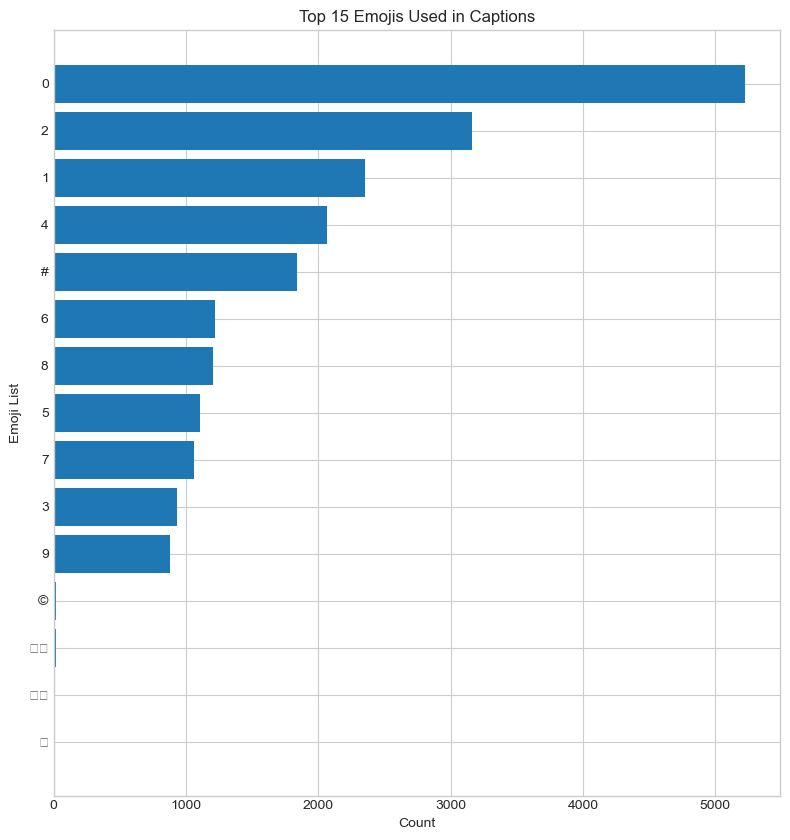

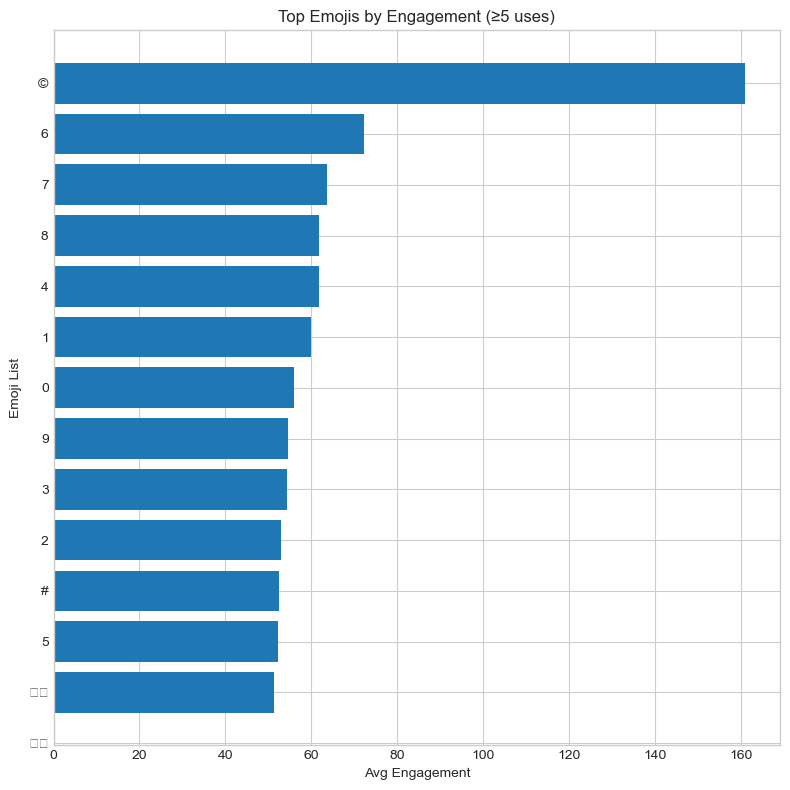


Saved CSV → /Users/faitusjelinejoseph/Documents/Project/Social/exports/emoji_stats.csv
Saved plots → /Users/faitusjelinejoseph/Documents/Project/Social/plots


In [10]:
# =============================
# Emoji Analysis (robust)
# =============================
import os
import regex as re
import matplotlib.pyplot as plt
import pandas as pd  # for safety if run standalone

# ---- Paths (adjust if needed)
EXPORT_DIR = "/Users/faitusjelinejoseph/Documents/Project/Social/exports"
PLOT_DIR   = "/Users/faitusjelinejoseph/Documents/Project/Social/plots"
os.makedirs(EXPORT_DIR, exist_ok=True)
os.makedirs(PLOT_DIR, exist_ok=True)

# If you're on macOS, this helps render emojis in charts
try:
    import matplotlib
    matplotlib.font_manager.fontManager.addfont("/System/Library/Fonts/Apple Color Emoji.ttc")
    plt.rcParams["font.family"] = "Apple Color Emoji"
except Exception:
    pass  # fallback to default font

# ---- Helpers
# We iterate by grapheme cluster (\X) and keep clusters containing any Emoji char.
GRAPHEME_RE = re.compile(r"\X", re.UNICODE)
HAS_EMOJI_RE = re.compile(r"\p{Emoji}", re.UNICODE)

def extract_emojis(text: str):
    if not isinstance(text, str) or not text:
        return []
    return [g for g in GRAPHEME_RE.findall(text) if HAS_EMOJI_RE.search(g)]

# Ensure merged_df exists from your pipeline
if "merged_df" not in globals():
    raise RuntimeError("merged_df not found. Run the data prep/merge section first.")

# Build emoji list per post
merged_df["emoji_list"] = merged_df["caption"].fillna("").apply(extract_emojis)

# Explode so each emoji is its own row
emoji_df = merged_df.explode("emoji_list").dropna(subset=["emoji_list"])

# Ensure engagements numeric for averaging, but don't drop posts without it
emoji_df["engagements_num"] = pd.to_numeric(emoji_df.get("engagements"), errors="coerce")

# Usage counts (all posts, regardless of engagements availability)
usage = (emoji_df.groupby("emoji_list")
         .size()
         .rename("count"))

# Average engagement (only rows with numeric engagements)
avg_eng = (emoji_df.dropna(subset=["engagements_num"])
           .groupby("emoji_list")["engagements_num"]
           .mean()
           .rename("avg_engagement"))

# Combine
emoji_stats = (pd.concat([usage, avg_eng], axis=1)
                 .reset_index()
                 .sort_values("count", ascending=False))

# Save summary
export_path = os.path.join(EXPORT_DIR, "emoji_stats.csv")
emoji_stats.to_csv(export_path, index=False)

print("\n=== Top Emojis by Usage ===")
print(emoji_stats.head(20))

print("\n=== Top Emojis by Engagement (min 5 uses) ===")
print(emoji_stats.query("count >= 5")
                 .sort_values("avg_engagement", ascending=False)
                 .head(20))

# =============================
# Visualizations (matplotlib)
# =============================

def _barh(df, x, y, title, outfile):
    if df.empty:
        print(f"[skip] No data for: {title}")
        return
    # reverse for largest at top
    d = df.iloc[::-1]
    plt.figure(figsize=(8, 0.5*len(d) + 1))
    plt.barh(d[y].astype(str), d[x])
    plt.xlabel(x.replace("_", " ").title())
    plt.ylabel(y.replace("_", " ").title())
    plt.title(title)
    plt.tight_layout()
    plt.savefig(outfile, dpi=150)
    plt.show()

# 1) Top 15 emojis by usage
top_usage = emoji_stats.head(15)
_barh(
    top_usage, x="count", y="emoji_list",
    title="Top 15 Emojis Used in Captions",
    outfile=os.path.join(PLOT_DIR, "top_emojis_usage.png")
)

# 2) Top 15 emojis by average engagement (min 5 uses)
top_eng = (emoji_stats.query("count >= 5")
           .sort_values("avg_engagement", ascending=False)
           .head(15))
_barh(
    top_eng, x="avg_engagement", y="emoji_list",
    title="Top Emojis by Engagement (≥5 uses)",
    outfile=os.path.join(PLOT_DIR, "top_emojis_engagement.png")
)

print(f"\nSaved CSV → {export_path}")
print(f"Saved plots → {PLOT_DIR}")
